In [3]:
library(ggplot2)
library(reshape2)

In [4]:
# Data preparation for plots

# 2 Select filename formats for each algorithm depending on parameters (copy values from runtest.sh)
ensemblesize <- "40" #ensemblesize <- "1_0.15_0.3_5_1_1" "1_0.15_0.3_60_10_1"  "1_0.15_0.3_120_30_1" #"1_0.15_0.3" # "60_0.1_0.25" # "45"
wsize <- 1000 #23000
seed <- "2" # "7" for NSGT-I

samplefrequency <- 500 # for RCD, as this is the batch size and we do not want to change results from the table.
problem <- c ("SPYsQ1Y17") # "SPY-20000", "NSGT-I", "SPY-october17x4"
batchsize <- 600

WARNING_ultra <- "0.3"
DRIFT_ultra <- "0.15"
WARNING_fast <- "0.01"
DRIFT_fast <- "0.001"
WARNING_moderate <- "0.0001"
DRIFT_moderate <- "0.00001"

parameters <- list()
parameters['RCARF'] = paste(ensemblesize,DRIFT_ultra,WARNING_ultra,"RCARF_ultra",sep="_")
parameters['RCARF_resize_all'] = paste(ensemblesize,DRIFT_ultra,WARNING_ultra,"RCARF_ultra_resize_all",sep="_")
#parameters['ARF_fast'] = paste(ensemblesize,DRIFT_fast,WARNING_fast,"ARF_fast",sep="_")
parameters['ARF_fast'] = paste(ensemblesize,"ARF_fast",sep="_")
#parameters['ARF_moderate'] = paste(ensemblesize,DRIFT_moderate,WARNING_moderate,"ARF_moderate",sep="_")
parameters['ARF_moderate'] = paste(ensemblesize,"ARF_moderate",sep="_")
parameters['ARF_ultra'] = paste(ensemblesize,DRIFT_ultra,WARNING_ultra,"ARF",sep="_")
parameters['DWM'] = "DWM"
parameters['RCD_HOEF'] = paste("RCD_HOEF",batchsize,ensemblesize,DRIFT_ultra,sep="_")
parameters['AHOEFT'] = "AHOEFT"
parameters['LNSETREE'] = paste("LNSETREE",batchsize,sep="_")

# Paths
datadir<-"/home/bin/moa/src/moa-2017.06-sources/experiments/results"
datasetdir <- "/home/bin/moa/src/moa-2017.06-sources/data/real"
averagesdir<-"/home/bin/moa/src/moa-2017.06-sources/experiments/results/averages"
seeddir <- paste (datadir, problem, seed, sep="/")
#pdfgraphicsdir= paste(datadir,"/averages/charts",sep="")
pdfgraphicsdir= paste(datadir,"/figures",sep="")

In [5]:
getWeekDates <- function (weekn){
    if      ( weekn == 1  ) return(c('2017-01-03','2017-01-04','2017-01-05','2017-01-06')) # "20170102" is New Year's day moved to Monday
    else if ( weekn == 2  ) return(c('2017-01-09','2017-01-10','2017-01-11','2017-01-12','2017-01-13')) 
    else if ( weekn == 3  ) return(c('2017-01-17','2017-01-18','2017-01-19','2017-01-20')) # "20170115" is Mr Luther King day, moved to the 16th 
    else if ( weekn == 4  ) return(c('2017-01-23','2017-01-24','2017-01-25','2017-01-26','2017-01-27')) 
    else if ( weekn == 5  ) return(c('2017-01-30','2017-01-31','2017-02-01','2017-02-02','2017-02-03')) 
    else if ( weekn == 6  ) return(c('2017-02-06','2017-02-07','2017-02-08','2017-02-09','2017-02-10')) 
    else if ( weekn == 7  ) return(c('2017-02-13','2017-02-14','2017-02-15','2017-02-16','2017-02-17')) 
    else if ( weekn == 8  ) return(c('2017-02-21','2017-02-22','2017-02-23','2017-02-24')) # "20170219" is President's day, moved to the 20th
    else if ( weekn == 9  ) return(c('2017-02-27','2017-02-28','2017-03-01','2017-03-02','2017-03-03')) 
    else if ( weekn == 10 ) return(c('2017-03-06','2017-03-07','2017-03-08','2017-03-09','2017-03-10')) 
    else if ( weekn == 11 ) return(c('2017-03-13','2017-03-14','2017-03-15','2017-03-16','2017-03-17')) 
    else if ( weekn == 12 ) return(c('2017-03-20','2017-03-21','2017-03-22','2017-03-23','2017-03-24')) 
    else if ( weekn == 13 ) return(c('2017-03-27','2017-03-28','2017-03-29','2017-03-30','2017-03-31'))
}

In [6]:
# For figure 7. Get row number for close of business in the given date 
getDateLimits <- function (dates, samplefrequency, index){
    limit <- list()
    for (date in dates) {
        limit[date] <- floor(which(index$V1 == paste(date,'T15:59:59.000000000',sep='')) / samplefrequency)
    }  
    return(unname(unlist(limit))) # return simple list without headers(dates)
}
#ceiling(which(index$V1 == '2017-01-06T09:30:35.000000000')/600) #floor()
#round(which(index$V1 == '2017-01-06T09:30:35.000000000')/600,0)

In [7]:
# For figure 6. Get row number for the last row on the given minute
getTimeLimits <- function (day, times, samplefrequency, index){
    limit <- list()
    for (time in times) {
        #print(time)
        #print(any(index$V1 == paste(day,'T',time,':59.000000000',sep='')))
        # If the price for the given second doesn't exist, we search for the previous one (if we don't have a price is because it didn't change)
        if (any(index$V1 == paste(day,'T',time,':59.000000000',sep='')))
            limit[time] <- floor(which(index$V1 == paste(day,'T',time,':59.000000000',sep='')) / samplefrequency)
        else 
            limit[time] <- floor(which(index$V1 == paste(day,'T',time,':58.000000000',sep='')) / samplefrequency)
    }  
    return(unname(unlist(limit))) # return simple list without headers(dates)
}

In [8]:
# Jupyter Notebooks chart size
options(repr.plot.width=8, repr.plot.height=4)

weeknumber=1

# Rows as row number or as an actual date
datemode = 0 # 0 for dates / 1 for rownumber 

if (datemode == 0){
    labels <-  getWeekDates(weeknumber)
    
    # Load Index for the first baseproblem
    index = read.csv(header = FALSE, paste(datasetdir,problem,paste(problem,"index.txt",sep="_"),sep="/"))
    xbreaks <- getDateLimits(dates = labels, samplefrequency, index)
    xrange <- c(5,xbreaks[length(xbreaks)])
    
} else {
    # Axes formatting functions
    labels <- function(x){format(x*samplefrequency, big.mark = ",", scientific = FALSE)}
    xbreaks <- c(5,10,15,20,25,30)   
    xrange <- c (0,30)
}

formatter_percent <- function(x){paste(x,'.0%',sep='')}

# Title (currently disables, change in function)
title <- "Algorithm performance overtime"

# Label titles
xlabel <- "Date" # "Number of Examples"
ylabel <- "Error (%)"

# The palette with black:
cbbPalette <- c("#000000", "#00CCCC", "#FF3300", "#E69F00", "#FF66FF","#006600","#0033FF", "#D55E00", "#CC79A7", "#56B4E9", "#F0E442","#0072B2")
# see colors in http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/

In [9]:
# Function that reads the results given in the path for each algorithm and returns a matrix of results
readForChart <- function (algorithms, parameters, ensemblesize, algolabels, problem, wsize, datadir) { 
    for (algorithm in algorithms){
        if (ensemblesize != "") datafile <- paste (problem, "_", parameters[algorithm],"_w",wsize,".txt",sep="")
        else datafile <- paste (problem, "_", algorithm,"_w",wsize,".txt",sep="")
        filename <- paste (datadir, datafile, sep="/")

        # Read and obtain all errors for the current algorithm file
        tempMatrix <- as.matrix(read.csv(filename, head=TRUE, sep=",")[,1:8])
        tempMatrix <- suppressWarnings(replace(tempMatrix ,is.na(as.numeric(tempMatrix)),0.0))
        error <- as.vector(100.0 - as.matrix(apply (tempMatrix,1:2,as.numeric))[,5])

        # Check if the result already exists
        if (exists("result")) result <- cbind ( result, error)
        else result <- error
        #print (result)

    } # this outputs a matrix of (algorithms x seeds) dimensions
    colnames(result) <- algolabels 
    return (result)
}

In [16]:
# Some of the settings of this plot are hardcoded to improve efficienty.
# The purpose of this function is to be a chart template for simple lineplots
plotChart <- function (data, xbreaks, xrange, yrange, cbbPalette, linewidth) { 
    p <- ggplot( melt(data), aes(x=as.numeric(as.vector(Var1)), y=value, col=Var2, linetype=Var2)) + geom_line(size=(0.35)*linewidth) + 
            scale_colour_manual(values=cbbPalette) + 
            scale_x_continuous(name=xlabel, breaks = xbreaks, limits = xrange, expand=c(0,0), labels = labels) +
            scale_y_continuous(name=ylabel, limits = yrange, expand=c(0,0), labels = formatter_percent)

    # Hide legend title
    p$labels$colour <- ""
    p$labels$linetype <- ""

    # Uncomment end of the following line to plot the title at the top
    p <- p + theme_minimal(base_size = 10) + guides(colour = guide_legend(nrow = 1)) + # ggtitle(title) + 
    # Extra formatting settings
    theme(legend.position = c(0.47, 0.1), legend.direction = "horizontal", 
          legend.background = element_rect(color = "grey40", fill = "white", size = 0.25, linetype = "solid"), 
          panel.border = element_rect(colour = "grey40", fill=NA, size=0.5),
          legend.key.width=unit(2,"line"), 
          panel.grid.major = element_line(colour = "grey85",size = 0.25),   
          panel.grid.minor = element_line(colour = "white")) #,
          #axis.line = element_line(colour = 'black', size = 1, linetype='solid',color='black')) # ,
    # Uncomment the following theme lines to edit axis and title font sizes
    #  axis.text.x=element_text(size=12), axis.title.x=element_text(size=12),
    #  axis.text.y=element_text(size=12), axis.title.y=element_text(size=12), 
    #  axis.line = element_line(colour = "black"), plot.title=element_text(size=16, face="bold", color="black"), panel.border = element_blank()) # themes
    return (p)
}
#Change tick mark labels
#
#The name of tick mark texts can be changed as follow :
#
## Solution 1
#p + scale_x_discrete(breaks=c("0.5","1","2"),
#        labels=c("Dose 0.5", "Dose 1", "Dose 2"))
## Solution 2 : same plot as solution 1
#p + scale_x_discrete(labels=c("0.5" = "Dose 0.5", "1" = "Dose 1",
#                              "2" = "Dose 2"))

In [ ]:
# PLOT 1: Figure 7
samplefrequency <- 1000
wsize <- 1000
problem <- c ("SPYsQ1Y17")

#cbbPalette <- c("#000000", "#00CCCC", "#FF3300", "#E69F00", "#FF66FF","#006600","#0033FF", "#D55E00", "#CC79A7", "#56B4E9", "#F0E442","#0072B2")
cbbPalette <- c("#000000", "#006600", "#f43202", "#d3a64e", "#FF66FF","#8c3d00","#0072B2")#, "#D55E00", "#CC79A7", "#56B4E9", "#F0E442","#0072B2")

#56B4E9

#E69F00 gold
#FFC85B yellow
#006600 darkgreen
#32CD32 brightgreen

# Show only from 20% to 60% for more visibility of the results
#yrange <- c (18,60) # c(20,60)
yrange <- c (29,39)
linewidth <- 1.5

## Decide timefame manually ##
weeknumber <- 11
labels <-  getWeekDates(weeknumber)
xbreaks <- getDateLimits(dates = labels, samplefrequency, index)
if (weeknumber == 1) { 
    # we omit the first window if the weeknumber == 1 (the first 500 examples of the total execution)
    xrange <- c(wsize/samplefrequency,xbreaks[length(xbreaks)]) 
} else { 
    # otherwise we start from the last row from last week
    lastweek <- getDateLimits(dates = getWeekDates(weeknumber - 1), samplefrequency, index)
    xrange <- c(lastweek[length(lastweek)], xbreaks[length(xbreaks)]) # - ((xbreaks[length(xbreaks)] - lastweek[length(lastweek)]) / 1.25)) 
}
## ################ ##
    
# Load data for chart using averages
algorithms <- c("RCARF","ARF_fast","ARF_ultra","ARF_moderate", "AHOEFT", "RCD_HOEF", "DWM")#,"RCARF_resize_all" "AHOEFT","LNSETREE","RCD_HOEF")
algolabels <- c("RCARF","ARFfast","ARFultra","ARFmoderate", "AHOEFT", "RCD", "DWM")#,"RCARF Dyn.Hist", "AHOEFT","LEARN++.NSE","RCD")
data.plot1 <- readForChart(algorithms, parameters, ensemblesize, algolabels, problem, wsize, paste(datadir,"averages",sep="/"))

#test
#data.plot1 <- readForChart(algorithms, parameters, ensemblesize, algolabels, problem, wsize, seeddir)

# Plot chart
plot1 <- plotChart(data.plot1, xbreaks, xrange, yrange, cbbPalette, linewidth) + #+ 
         theme(axis.text.x = element_text(margin = margin(t=-0.25, b=0.25, unit = "cm"), hjust = 1.85),
               axis.text.y = element_text(margin = margin(r=-0.3, l=0.25,  unit = "cm")))
         #axis.text.x = element_text(angle = 45, hjust = 1))
         
plot1 

#ggsave(filename=paste(pdfgraphicsdir,"figure7.pdf",sep="/"), plot=plot4, device="pdf", width = 8, height = 4) # no permissions
ggsave(filename=paste(pdfgraphicsdir,"/figure7",problem,"_week",weeknumber,".pdf",sep=""), plot=plot1, device="pdf", width = 8, height = 4)

Warning message:
“Removed 6804 rows containing missing values (geom_path).”

Warning message:
“Removed 6804 rows containing missing values (geom_path).”

In [12]:
# PLOT 1: Figure 7
samplefrequency <- 1000
problem <- c ("SPYsQ1Y17")
wsize <- 1000
#cbbPalette <- c("#000000", "#006600", "#f43202", "#FFC85B", "#FF66FF","#D55E00","#0072B2")#, "#D55E00", "#CC79A7", "#56B4E9", "#F0E442","#0072B2")
cbbPalette <- c("#000000", "#006600", "#f43202", "#d3a64e", "#FF66FF","#8c3d00","#0072B2")#, "#D55E00", "#CC79A7", "#56B4E9", "#F0E442","#0072B2")

# Show only from 20% to 60% for more visibility of the results
yrange <- c (29,39)
linewidth <- 1.5

## Decide timefame manually ##
weeks <- 1:13

for(weeknumber in weeks){
    labels <-  getWeekDates(weeknumber)
    xbreaks <- getDateLimits(dates = labels, samplefrequency, index)
    if (weeknumber == 1) { 
        # we omit the first window if the weeknumber == 1 (the first 500 examples of the total execution)
        xrange <- c(wsize/samplefrequency,xbreaks[length(xbreaks)]) 
    } else { 
        # otherwise we start from the last row from last week
        lastweek <- getDateLimits(dates = getWeekDates(weeknumber - 1), samplefrequency, index)
        xrange <- c(lastweek[length(lastweek)], xbreaks[length(xbreaks)]) # - ((xbreaks[length(xbreaks)] - lastweek[length(lastweek)]) / 1.25)) 
    }

    # Load data for chart using averages
    algorithms <- c("RCARF","ARF_fast","ARF_ultra","ARF_moderate", "AHOEFT", "RCD_HOEF", "DWM")
    algolabels <- c("RCARF","ARFfast","ARFultra","ARFmoderate", "AHOEFT", "RCD", "DWM")
    data.plot1 <- readForChart(algorithms, parameters, ensemblesize, algolabels, problem, wsize, paste(datadir,"averages",sep="/"))

    # Plot chart
    plot1 <- plotChart(data.plot1, xbreaks, xrange, yrange, cbbPalette, linewidth) + #+ 
             theme(axis.text.x = element_text(margin = margin(t=-0.25, b=0.25, unit = "cm"), hjust = 1.85),
                   axis.text.y = element_text(margin = margin(r=-0.3, l=0.25,  unit = "cm")))         

    ggsave(filename=paste(pdfgraphicsdir,"/figure7",problem,"_week",weeknumber,".pdf",sep=""), plot=plot1, device="pdf", width = 8, height = 4)
}

Warning message:
“Removed 6907 rows containing missing values (geom_path).”Warning message:
“Removed 6797 rows containing missing values (geom_path).”Warning message:
“Removed 6916 rows containing missing values (geom_path).”Warning message:
“Removed 6804 rows containing missing values (geom_path).”Warning message:
“Removed 6783 rows containing missing values (geom_path).”Warning message:
“Removed 6839 rows containing missing values (geom_path).”Warning message:
“Removed 6790 rows containing missing values (geom_path).”Warning message:
“Removed 6902 rows containing missing values (geom_path).”Warning message:
“Removed 6769 rows containing missing values (geom_path).”Warning message:
“Removed 6811 rows containing missing values (geom_path).”Warning message:
“Removed 6804 rows containing missing values (geom_path).”Warning message:
“Removed 6741 rows containing missing values (geom_path).”Warning message:
“Removed 6803 rows containing missing values (geom_path).”

In [19]:
# Some of the settings of this plot are hardcoded to improve efficienty.
# The purpose of this function is to be a chart template for simple lineplots
# metal blue: #0072B2
plotChartDrifts <- function (data, xbreaks, xrange, yrange,  nonrecurringdrifts, recurringdrifts, cbbPalette, linewidth) { 
    p <- ggplot( melt(data), aes(x=as.numeric(as.vector(Var1)), y=value, col=Var2, linetype=Var2)) + 
            # Background Drifts
            geom_vline(xintercept = as.vector(nonrecurringdrifts/samplefrequency), linetype="dotted" , colour="#BB0000", show.legend = TRUE) +
            # Recurring Drifts
            geom_vline(xintercept = as.vector(recurringdrifts/samplefrequency)   , linetype="dashed", colour="#0072B2", show.legend = TRUE) +
            # Different line types: blank", "solid", "dashed", "dotted", "dotdash", "longdash", "twodash", "1F", "F1", "4C88C488", "12345678"
            geom_line(size=(0.35)*linewidth, show.legend = FALSE) +        
            # Scale
            scale_colour_manual(values=cbbPalette) + 
            scale_x_continuous(name=xlabel, breaks = xbreaks, limits = xrange, expand=c(0,0), labels = labels) +
            scale_y_continuous(name=ylabel, limits = yrange, expand=c(0,0), labels = formatter_percent)
    
    # Hide legend title
    p$labels$colour <- ""
    p$labels$linetype <- ""

    # Uncomment end of the following line to plot the title at the top
    p <- p + theme_minimal(base_size = 10) + guides(colour = guide_legend(nrow = 1)) + # ggtitle(title) + 
    # Extra formatting settings
    theme(legend.position = c(0.47, 0.1), legend.direction = "horizontal", 
          legend.background = element_rect(color = "grey40", fill = "white", size = 0.25, linetype = "solid"), 
          panel.border = element_rect(colour = "grey40", fill=NA, size=0.5),
          legend.key.width=unit(2,"line"), 
          panel.grid.major = element_line(colour = "grey80",size = 0.25),   
          panel.grid.minor = element_line(colour = "white")) # ,
    # Uncomment the following theme lines to edit axis and title font sizes
    #  axis.text.x=element_text(size=12), axis.title.x=element_text(size=12),
    #  axis.text.y=element_text(size=12), axis.title.y=element_text(size=12), 
    #  axis.line = element_line(colour = "black"), plot.title=element_text(size=16, face="bold", color="black"), panel.border = element_blank()) # themes
    return (p)
}

Warning message:
“Removed 5 rows containing missing values (geom_vline).”Warning message:
“Removed 8 rows containing missing values (geom_vline).”Warning message:
“Removed 98 rows containing missing values (geom_path).”

Warning message:
“Removed 5 rows containing missing values (geom_vline).”Warning message:
“Removed 8 rows containing missing values (geom_vline).”Warning message:
“Removed 98 rows containing missing values (geom_path).”

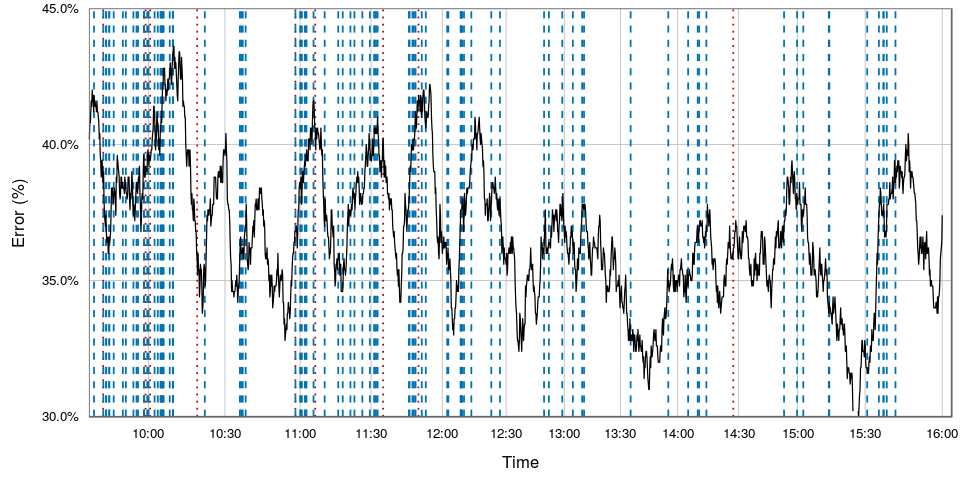

In [21]:
# PLOT 2: Figure 6
# This one is a bit different, as it also shows background (non recurring) and recurring drifts
samplefrequency <- 10
wsize <-500

problem <- c ("SPYsQ1Y17firstDay")
seed <- "1"
seeddir <- paste (datadir, problem, seed, sep="/")

# Show only from 20% to 50% for more visibility of the results
yrange <- c(30,45) # c (0,10) 
linewidth <- 1
xlabel <- "Time" 

# Palette for this chart
cbbPalette <- c("#000000", "#E69F00")

## Decide timeframe manually ##
limits <-  c ('09:30','10:00','10:30','11:00','11:30','12:00','12:30','13:00','13:30','14:00','14:30','15:00','15:30','15:59')
labels <-  c ('09:30','10:00','10:30','11:00','11:30','12:00','12:30','13:00','13:30','14:00','14:30','15:00','15:30','16:00')
xbreaks <- getTimeLimits(day = '2017-01-03', times = limits, samplefrequency, index)
xrange <- c(wsize/samplefrequency,xbreaks[length(xbreaks)]+20) # omitting the first window and add extra 15 rows to avoid cropping last time in axis
#xrange <- c(0,xbreaks[length(xbreaks)]) # showing all

# Load data for chart for a single seed
algorithms <- c("RCARF","RCARF")
algolabels <- c("RCARF ultrafast","RCARF ultrafast")

seeddir <- paste(datadir,problem,seed,sep="/")
data.plot4 <- readForChart(algorithms, parameters, ensemblesize, algolabels, problem, wsize, seeddir)

# Read outputs of the concept drifts analysis
rdrifts.filename <- paste(problem,parameters['RCARF'],paste('w',wsize,sep=''),'recurring_drifts.txt',sep='_')
nrdrifts.filename <- paste(problem,parameters['RCARF'],paste('w',wsize,sep=''),'non_recurring_drifts.txt',sep='_')
nonrecurringdrifts <- as.vector(read.csv(paste(seeddir,nrdrifts.filename,sep="/"), head=FALSE, sep=",")[,1])
recurringdrifts <- as.vector(read.csv(paste(seeddir,rdrifts.filename,sep="/"), head=FALSE, sep=",")[,1])

# Plot chart with extra vertical lines showing recurring drifts and non recurring drifts
plot4 <- plotChartDrifts(data.plot4, xbreaks, xrange, yrange, nonrecurringdrifts, recurringdrifts, cbbPalette, linewidth) + 
             theme(axis.text.x = element_text(margin = margin(t=-0.25, b=0.25, unit = "cm")),
                   axis.text.y = element_text(margin = margin(r=-0.3, l=0.25,  unit = "cm")))
            #theme(axis.text.x = element_text(angle = 45, hjust = 1))
plot4

# Print the plot to a pdf file
ggsave(filename=paste(pdfgraphicsdir,"/figure6_",problem,"_",ensemblesize,"_seed",seed,"_","_w",wsize,".pdf",sep=""), plot=plot4, device="pdf", width = 8, height = 4)

In [ ]:
# PLOT 2

# Show only from 22% to 43% for more visibility of the results
yrange <- c (25,50) # c(20,60)
linewidth <- 1

# Load data for chart using averages
algorithms <- c("RCARF","ARF_ultra","ARF_fast","ARF_moderate") # "RCARF_resize_all"
algolabels <- c("RCARF","ARF ultra","ARF fast","ARF_moderate") # "RCARF Dyn.Hist"
data.plot2 <- readForChart(algorithms, parameters, ensemblesize, algolabels, problem, wsize, paste(datadir,"averages",sep="/"))

# Plot chart
plot2 <- plotChart(data.plot2, xbreaks, xrange, yrange, cbbPalette, linewidth) + 
         theme(axis.text.x = element_text(angle = 45, hjust = 1))
plot2

#ggsave(filename=paste(problem,"w500_comparison.pdf",sep=""), plot=plot2, device="pdf", width = 8, height = 4)

In [52]:
# PLOT 3

# Show only from 20% to 60% for more visibility of the results
yrange <- c (25,45) # c(20,60)
linewidth <- 1

# Load data for chart using averages
algorithms <- c("RCARF","ARF_moderate", "AHOEFT", "DWM", "RCD_HOEF") # "LNSETREE"
algolabels <- c("RCARF","ARF moderate", "AHOEFT", "DWM", "RCD HOEFT") # "LEARN++.NSE"
data.plot3 <- readForChart(algorithms, parameters, ensemblesize, algolabels, problem, wsize, paste(datadir,"averages",sep="/"))
# TODO. add variable ensemblesize, which shouldnt work for AHOEFT,LNSETREE AND RCD (act like blank ensemblesize)

# Plot chart
plot3 <- plotChart(data.plot3, xbreaks, xrange, yrange, cbbPalette, linewidth) +
         theme(axis.text.x = element_text(angle = 45, hjust = 1))
plot3 

#ggsave(filename=paste(problem,"w500_comparison_2.pdf",sep=""), plot=plot3, device="pdf", width = 8, height = 4)

Warning message in file(file, "rt"):
“cannot open file '/home/bin/moa/src/moa-2017.06-sources/experiments/results/averages/SPYsQ1Y17_40_0.15_0.3_RCARF_ultra_w23000.txt': No such file or directory”

ERROR: Error in file(file, "rt"): cannot open the connection


Warning message:
“Removed 62 rows containing missing values (geom_path).”

Warning message:
“Removed 62 rows containing missing values (geom_path).”

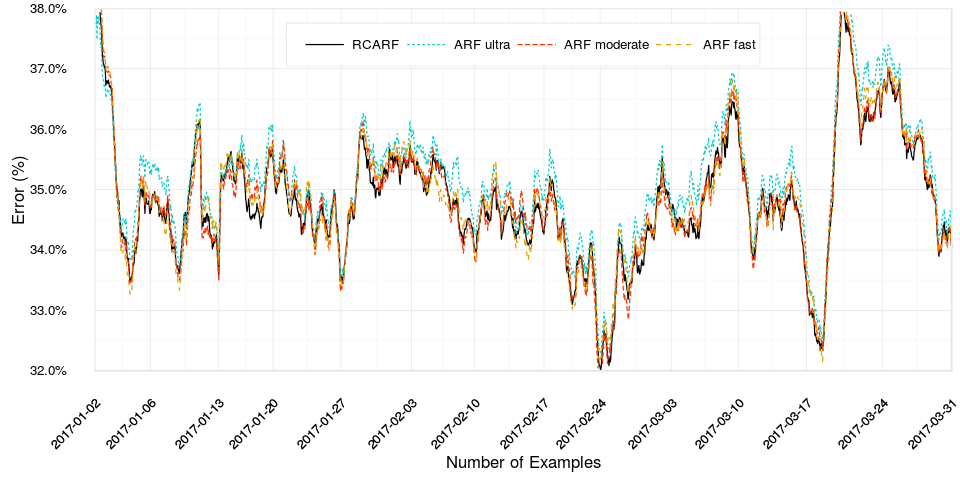

In [60]:
# PLOT 4.5: This one is a bit different, as it also shows background (non recurring) and recurring drifts

# Show only from 20% to 50% for more visibility of the results
#yrange <- c (18,50) # c(20,50)
yrange <- c(32,38) # c (0,10) 
linewidth <- 1

# Palette for this chart
cbbPalette <- c("#000000", "#00CCCC", "#FF3300", "#E69F00", "#FF66FF","#006600","#0033FF", "#D55E00", "#CC79A7", "#56B4E9", "#F0E442","#0072B2")


# Load data for chart for a single seed
algorithms <- c("RCARF","ARF_ultra","ARF_moderate", "ARF_fast")#, "AHOEFT", "DWM", "RCD_HOEF") # "LNSETREE"
algolabels <- c("RCARF","ARF ultra","ARF moderate", "ARF fast")#, "AHOEFT", "DWM", "RCD") # "LEARN++.NSE"

seeddir <- paste(datadir,problem,seed,sep="/")
data.plot45 <- readForChart(algorithms, parameters, ensemblesize, algolabels, problem, wsize, seeddir)

# Read outputs of the concept drifts analysis
# TODO. add ensemble size to path in drifts
#rdrifts.filename <- paaste(problem,parameters['RCARF'],paste('w',wsize,sep=''),'recurring_drifts.txt',sep='_')
#nrdrifts.filename <- paste(problem,parameters['RCARF'],paste('w',wsize,sep=''),'non_recurring_drifts.txt',sep='_')
#nonrecurringdrifts <- as.vector(read.csv(paste(seeddir,nrdrifts.filename,sep="/"), head=FALSE, sep=",")[,1])
#recurringdrifts <- as.vector(read.csv(paste(seeddir,rdrifts.filename,sep="/"), head=FALSE, sep=",")[,1])

# Plot chart with extra vertical lines showing recurring drifts and non recurring drifts
plot45 <- plotChart(data.plot45, xbreaks, xrange, yrange, cbbPalette, linewidth) + 
        #geom_vline(xintercept = as.vector(nonrecurringdrifts/samplefrequency), linetype="dotted", colour="#BB0000", show.legend = TRUE) + 
        #geom_vline(xintercept = as.vector(recurringdrifts/samplefrequency), linetype="dotdash", colour="#0072B2", show.legend = TRUE) +
        theme(axis.text.x = element_text(angle = 45, hjust = 1))
# Different line types: blank", "solid", "dashed", "dotted", "dotdash", "longdash", "twodash", "1F", "F1", "4C88C488", "12345678"
plot45

# Print the plot to a pdf file
#ggsave(filename=paste(pdfgraphicsdir,"figure6.pdf",sep="/"), plot=plot4, device="pdf", width = 8, height = 4) # no permissions
ggsave(filename=paste("figure6.1_",problem,"_",ensemblesize,"_w",wsize,".pdf",sep=""), plot=plot45, device="pdf", width = 8, height = 4)

Warning message:
“Removed 510 rows containing missing values (geom_path).”Warning message:
“Removed 17 rows containing missing values (geom_vline).”Warning message:
“Removed 353 rows containing missing values (geom_vline).”

Warning message:
“Removed 510 rows containing missing values (geom_path).”Warning message:
“Removed 17 rows containing missing values (geom_vline).”Warning message:
“Removed 353 rows containing missing values (geom_vline).”

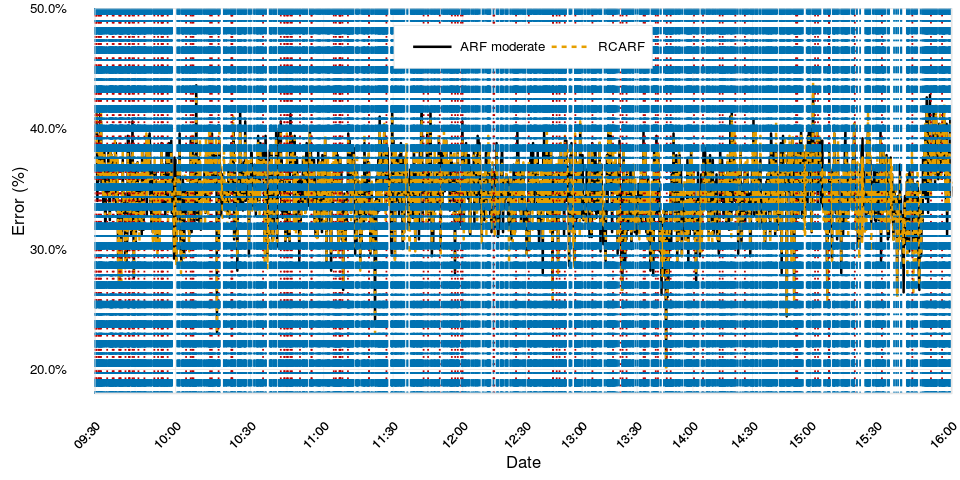

In [44]:
# PLOT 5: 

# Show only from 20% to 50% for more visibility of the results
yrange <- c (18,50) # c(20,50)
linewidth <- 2

seed <- "1" # "7" for NSGT-I
seeddir <- paste (datadir, problem, seed, sep="/")

# Palette for this chart
cbbPalette <- c("#000000", "#E69F00")

# Load data for chart for a single seed
algorithms <- c("ARF_moderate","RCARF")
algolabels <- c("ARF moderate","RCARF")

seeddir <- paste(datadir,problem,seed,sep="/")
data.plot5 <- readForChart(algorithms, parameters, ensemblesize, algolabels, problem, wsize, seeddir)

# Read outputs of the concept drifts analysis
rdrifts.filename <- paste(problem,parameters['RCARF'],paste('w',wsize,sep=''),'recurring_drifts.txt',sep='_')
nrdrifts.filename <- paste(problem,parameters['RCARF'],paste('w',wsize,sep=''),'non_recurring_drifts.txt',sep='_')
nonrecurringdrifts <- as.vector(read.csv(paste(seeddir,nrdrifts.filename,sep="/"), head=FALSE, sep=",")[,1])
recurringdrifts <- as.vector(read.csv(paste(seeddir,rdrifts.filename,sep="/"), head=FALSE, sep=",")[,1])

# Plot chart with extra vertical lines showing recurring drifts and non recurring drifts
plot5 <- plotChart(data.plot5, xbreaks, xrange, yrange, cbbPalette, linewidth) + 
        geom_vline(xintercept = as.vector(nonrecurringdrifts/samplefrequency), linetype="dotted", colour="#BB0000", show.legend = TRUE) + 
        geom_vline(xintercept = as.vector(recurringdrifts/samplefrequency), linetype="dotdash", colour="#0072B2", show.legend = TRUE) +
        theme(axis.text.x = element_text(angle = 45, hjust = 1))
# Different line types: blank", "solid", "dashed", "dotted", "dotdash", "longdash", "twodash", "1F", "F1", "4C88C488", "12345678"
plot5

# Print the plot to a pdf file
#ggsave(filename=paste(pdfgraphicsdir,"figure6.pdf",sep="/"), plot=plot4, device="pdf", width = 8, height = 4) # no permissions
ggsave(filename=paste("figure6_",problem,"_",ensemblesize,"_w",wsize,"_alternative1.pdf",sep=""), plot=plot5, device="pdf", width = 8, height = 4)

In [24]:
# PLOT 6: 

# Show only from 20% to 50% for more visibility of the results
yrange <- c (18,50) # c(20,50)
linewidth <- 2

# Palette for this chart
cbbPalette <- c("#000000", "#E69F00")

# Load data for chart for a single seed
algorithms <- c("RCARF","RCARF_fast")
algolabels <- c("RCARF","RCARF fast")

seeddir <- paste(datadir,problem,seed,sep="/")
data.plot7 <- readForChart(algorithms, ensemblesize, algolabels, problem, wsize, seeddir)

# Read outputs of the concept drifts analysis for RCARF
rdrifts.filename <- paste(problem,parameters, ensemblesize,'RCARF','w500','recurring_drifts.txt',sep='_')
nrdrifts.filename <- paste(problem,parameters, ensemblesize,'RCARF','w500','non_recurring_drifts.txt',sep='_')
recurringdrifts <- as.vector(read.csv(paste(seeddir,rdrifts.filename,sep="/"), head=FALSE, sep=",")[,1])
nonrecurringdrifts <- as.vector(read.csv(paste(seeddir,nrdrifts.filename,sep="/"), head=FALSE, sep=",")[,1])

# Read outputs of the concept drifts analysis for RCARFfast
#fast.rdrifts.filename <- paste(problem,'RCARFfast','w500','recurring_drifts.txt',sep='_')
#fast.nrdrifts.filename <- paste(problem,'RCARFfast','w500','non_recurring_drifts.txt',sep='_')
#fastrecurringdrifts <- as.vector(read.csv(paste(seeddir,fast.rdrifts.filename,sep="/"), head=FALSE, sep=",")[,1])
#fastnonrecurringdrifts <- as.vector(read.csv(paste(seeddir,fast.nrdrifts.filename,sep="/"), head=FALSE, sep=",")[,1])

# Plot chart with extra vertical lines showing recurring drifts and non recurring drifts
plot7 <- plotChart(data.plot7, xbreaks, xrange, yrange, cbbPalette, linewidth) + 
        # Red: Bgk RCARF / Strong blue: Recurring RCARF 
        geom_vline(xintercept = as.vector(nonrecurringdrifts/10), linetype="dotted", colour="#BB0000", show.legend = TRUE) + 
        geom_vline(xintercept = as.vector(recurringdrifts/10), linetype="dotdash", colour="#0072B2", show.legend = TRUE) # + 
        # Green: Bgk RCARFfast / Pink: Recurring RCARFfast
        #geom_vline(xintercept = as.vector(fastnonrecurringdrifts/10), linetype="twodash", colour="#00CCCC", show.legend = TRUE) + 
        #geom_vline(xintercept = as.vector(fastrecurringdrifts/10), linetype="solid", colour="#FF66FF", show.legend = TRUE) 
# Different line types: blank", "solid", "dashed", "dotted", "dotdash", "longdash", "twodash", "1F", "F1", "4C88C488", "12345678"
plot7
                   
# Print the plot to a pdf file
#ggsave(filename=paste(pdfgraphicsdir,"figure6.pdf",sep="/"), plot=plot4, device="pdf", width = 8, height = 4) # no permissions
ggsave(filename=paste("figure6_",problem,"_",ensemblesize,"_alternative3.pdf",sep=""), plot=plot7, device="pdf", width = 8, height = 4)
ggsave(filename=paste("figure6_",problem,"_",ensemblesize,"_alternative3_hidingdrifts.pdf",sep=""), plot=plotChart(data.plot7, xbreaks, xrange, yrange, cbbPalette, linewidth), device="pdf", width = 8, height = 4)

Warning message in file(file, "rt"):
“cannot open file '/home/bin/moa/src/moa-2017.06-sources/experiments/results/SPY-october17x4/1/SPY-october17x4_1_0.15_0.3_RCARF_fast_w500.txt': No such file or directory”

ERROR: Error in file(file, "rt"): cannot open the connection


In [23]:
# PLOT 6: 

# Show only from 20% to 50% for more visibility of the results
yrange <- c (18,50) # c(20,50)
linewidth <- 2

# Palette for this chart
cbbPalette <- c("#000000", "#E69F00")

# Load data for chart for a single seed
algorithms <- c("ARF_fast","RCARF_fast")
algolabels <- c("ARF fast","RCARF fast")

seeddir <- paste(datadir,problem,seed,sep="/")
data.plot6 <- readForChart(algorithms, algolabels, problem, wsize, seeddir)

# Read outputs of the concept drifts analysis
#rdrifts.filename <- paste(problem,'RCARFfast','w500','recurring_drifts.txt',sep='_')
#nrdrifts.filename <- paste(problem,'RCARFfast','w500','non_recurring_drifts.txt',sep='_')
#nonrecurringdrifts <- as.vector(read.csv(paste(seeddir,nrdrifts.filename,sep="/"), head=FALSE, sep=",")[,1])
#recurringdrifts <- as.vector(read.csv(paste(seeddir,rdrifts.filename,sep="/"), head=FALSE, sep=",")[,1])

# Plot chart with extra vertical lines showing recurring drifts and non recurring drifts
plot6 <- plotChart(data.plot6, xbreaks, xrange, yrange, cbbPalette, linewidth) #+ 
        #geom_vline(xintercept = as.vector(nonrecurringdrifts/10), linetype="dotted", colour="#BB0000", show.legend = TRUE) + 
        #geom_vline(xintercept = as.vector(recurringdrifts/10), linetype="dotdash", colour="#0072B2", show.legend = TRUE)
# Different line types: blank", "solid", "dashed", "dotted", "dotdash", "longdash", "twodash", "1F", "F1", "4C88C488", "12345678"
plot6

# Print the plot to a pdf file
#ggsave(filename=paste(pdfgraphicsdir,"figure6.pdf",sep="/"), plot=plot4, device="pdf", width = 8, height = 4) # no permissions
ggsave(filename=paste("figure6_",problem,"_alternative2.pdf",sep=""), plot=plot6, device="pdf", width = 8, height = 4)

Warning message in if (ensemblesize != "") datafile <- paste(problem, "_", ensemblesize, :
“the condition has length > 1 and only the first element will be used”

ERROR: Error in paste(datadir, datafile, sep = "/"): argument "datadir" is missing, with no default


Warning message:
“Removed 8 rows containing missing values (geom_path).”

Warning message:
“Removed 8 rows containing missing values (geom_path).”

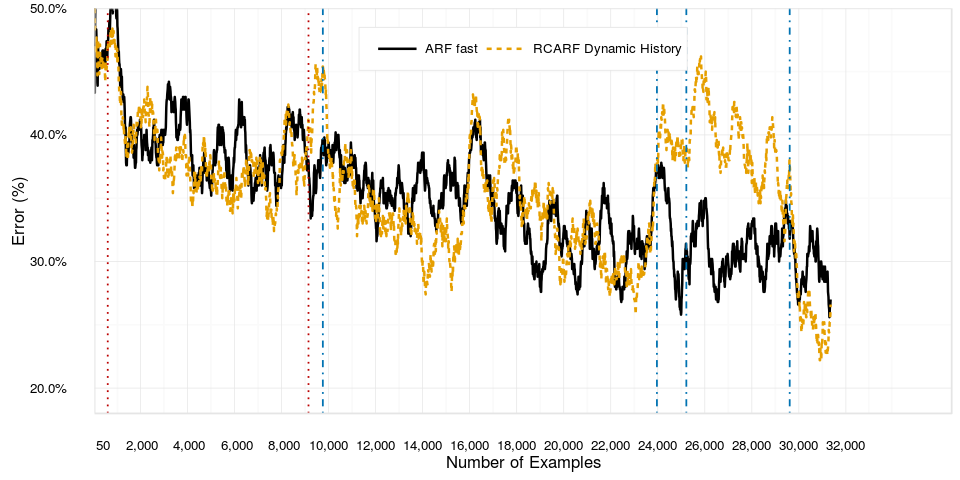

In [27]:
# PLOT 7: 

# Show only from 20% to 50% for more visibility of the results
yrange <- c (18,50) # c(20,50)
linewidth <- 2
seed <- 2

# Palette for this chart
cbbPalette <- c("#000000", "#E69F00")

# Load data for chart for a single seed
algorithms <- c("ARF_fast","RCARF_resize_all")
algolabels <- c("ARF fast ","RCARF Dynamic History")

seeddir <- paste(datadir,problem,seed,sep="/")
data.plot5 <- readForChart(algorithms, ensemblesize, algolabels, problem, wsize, seeddir)

# Read outputs of the concept drifts analysis
rdrifts.filename <- paste(problem,ensemblesize,'RCARF_resize_all','w500','recurring_drifts.txt',sep='_')
nrdrifts.filename <- paste(problem,ensemblesize,'RCARF_resize_all','w500','non_recurring_drifts.txt',sep='_')
nonrecurringdrifts <- as.vector(read.csv(paste(seeddir,nrdrifts.filename,sep="/"), head=FALSE, sep=",")[,1])
recurringdrifts <- as.vector(read.csv(paste(seeddir,rdrifts.filename,sep="/"), head=FALSE, sep=",")[,1])

# Plot chart with extra vertical lines showing recurring drifts and non recurring drifts
plot5 <- plotChart(data.plot5, xbreaks, xrange, yrange, cbbPalette, linewidth) + 
        geom_vline(xintercept = as.vector(nonrecurringdrifts/10), linetype="dotted", colour="#BB0000", show.legend = TRUE) + 
        geom_vline(xintercept = as.vector(recurringdrifts/10), linetype="dotdash", colour="#0072B2", show.legend = TRUE)
# Different line types: blank", "solid", "dashed", "dotted", "dotdash", "longdash", "twodash", "1F", "F1", "4C88C488", "12345678"
plot5

# Print the plot to a pdf file
#ggsave(filename=paste(pdfgraphicsdir,"figure6.pdf",sep="/"), plot=plot4, device="pdf", width = 8, height = 4) # no permissions
ggsave(filename=paste("figure6_",problem,"_",ensemblesize,"_alternative4.pdf",sep=""), plot=plot5, device="pdf", width = 8, height = 4)


In [6]:
# Function that reads the results given in the path for each algorithm and returns a matrix of results
readForChartsWithSettings <- function (algorithms, parameters, algolabels, problem, wsize, datadir) { 
    for (algorithm in algorithms){
        if (parameters != "" && parameters[algorithm] != "") {
            datafile <- paste (problem,"_",parameters[algorithm],"_w",wsize,".txt",sep="")
        } else datafile <- paste (problem,"_",algorithm,"_w",wsize,".txt",sep="")
        filename <- paste (datadir, datafile, sep="/")

        # Read and obtain all errors for the current algorithm file
        tempMatrix <- as.matrix(read.csv(filename, head=TRUE, sep=",")[,1:8])
        tempMatrix <- suppressWarnings(replace(tempMatrix ,is.na(as.numeric(tempMatrix)),0.0))
        error <- as.vector(100.0 - as.matrix(apply (tempMatrix,1:2,as.numeric))[,5])

        #print(algorithm)
        #print(error)
            
        # Check if the result already exists
        if (exists("result")) result <- cbind ( result, error)
        else result <- error
        #print (result)

    } # this outputs a matrix of (algorithms x seeds) dimensions
    colnames(result) <- algolabels 
    return (result)
}

In [7]:
# 2 Select filename formats for each algorithm depending on parameters (copy values from runtest.sh)
samplefrequency <- 600
ensemblesize <- "1" # "1_0.15_0.3" # "15_0.15_0.3"  # "45_0.15_0.3" #"60_0.1_0.25" # "45"
#15 40
#ensemblesize <- "40" # "1_0.15_0.3" # "15_0.15_0.3"  # "45_0.15_0.3" #"60_0.1_0.25" # "45"
seeds <- 1:20 # 5

WARNING_ultra <- "0.3"
DRIFT_ultra <- "0.15"
WARNING_fast <- "0.01"
DRIFT_fast <- "0.001"
WARNING_moderate <- "0.0001"
DRIFT_moderate <- "0.00001"

parameters <- list()

parameters['RCARF'] = paste(ensemblesize,DRIFT_ultra,WARNING_ultra,"RCARF_ultra",sep="_")
parameters['RCARF_resize_all'] = paste(ensemblesize,DRIFT_ultra,WARNING_ultra,"RCARF_ultra_resize_all",sep="_")
#parameters['ARF_fast'] = paste(ensemblesize,DRIFT_fast,WARNING_fast,"ARF_fast",sep="_")
parameters['ARF_fast'] = paste(ensemblesize,"ARF_fast",sep="_")
#parameters['ARF_moderate'] = paste(ensemblesize,DRIFT_moderate,WARNING_moderate,"ARF_moderate",sep="_")
parameters['ARF_moderate'] = paste(ensemblesize,"ARF_moderate",sep="_")
parameters['ARF_ultra'] = paste(ensemblesize,DRIFT_ultra,WARNING_ultra,"ARF",sep="_")
parameters['DWM'] = "DWM"
parameters['RCD_HOEF'] = paste("RCD_HOEF",samplefrequency,ensemblesize,DRIFT_ultra,sep="_")
parameters['AHOEFT'] = "AHOEFT"
parameters['LNSETREE'] = paste("LNSETREE",samplefrequency,sep="_")

parameters['RCARF_def'] = paste(ensemblesize,DRIFT_ultra,WARNING_ultra,"RCARF",sep="_")
parameters['RCARF_1'] = paste("RCARF_ultra",ensemblesize,DRIFT_ultra,WARNING_ultra,5,1,1,sep="_")
parameters['RCARF_2'] = paste("RCARF_ultra",ensemblesize,DRIFT_ultra,WARNING_ultra,60,10,1,sep="_")
parameters['RCARF_3'] = paste("RCARF_ultra",ensemblesize,DRIFT_ultra,WARNING_ultra,120,30,1,sep="_")
parameters['rRCARF_1'] = paste(ensemblesize,DRIFT_ultra,WARNING_ultra,5,1,1,"RCARF_ultra",sep="_")
parameters['rRCARF_2'] = paste(ensemblesize,DRIFT_ultra,WARNING_ultra,60,10,1,"RCARF_ultra",sep="_")
parameters['rRCARF_3'] = paste(ensemblesize,DRIFT_ultra,WARNING_ultra,120,30,1,"RCARF_ultra",sep="_")

Warning message:
“Removed 16 rows containing missing values (geom_path).”

Warning message:
“Removed 16 rows containing missing values (geom_path).”

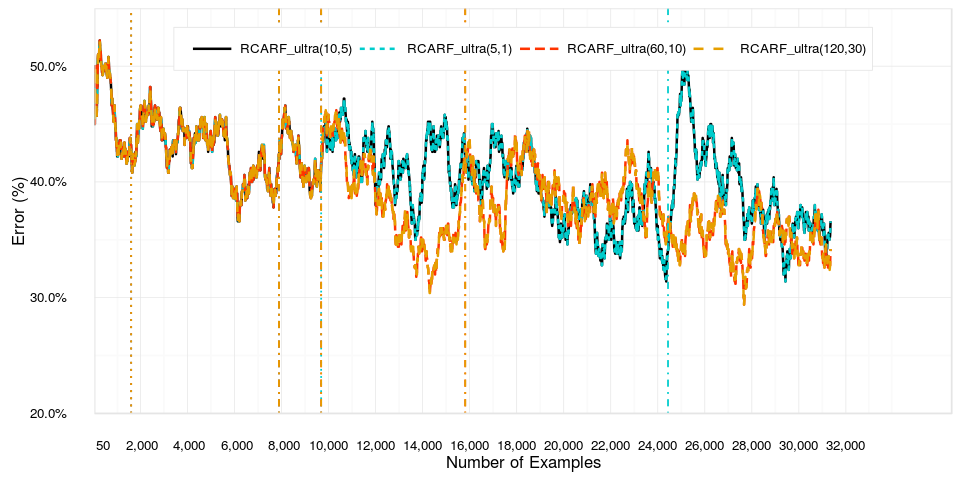

In [18]:
# PLOT 8: 

# TO-DO: modify functions to be able to send different charts with different ensemble sizes. 
#each algorithm should have its won config. do something like in the second script (split tables)

# Show only from 20% to 50% for more visibility of the results
yrange <- c (20,55) # c(20,50)
linewidth <- 2

# Palette for this chart
#cbbPalette <- c("#000000", "#E69F00")
cbbPalette <- c("#000000", "#00CCCC", "#FF3300", "#E69F00", "#FF66FF","#006600","#0033FF", "#D55E00", "#CC79A7", "#56B4E9", "#F0E442","#0072B2")

# Load data for chart for a single seed
algorithms <- c("RCARF_def","RCARF_1","RCARF_2","RCARF_3")
algolabels <- c("RCARF_ultra(10,5)","RCARF_ultra(5,1)","RCARF_ultra(60,10)","RCARF_ultra(120,30)")

seed <- 20 # 5 6 8 10 14 18 20
seeddir <- paste(datadir,problem,seed,sep="/")
data.plot8 <- readForChartsWithSettings(algorithms, parameters, algolabels, problem, wsize, seeddir)

# Read outputs of the concept drifts analysis
rdrifts.filename <- paste(problem,parameters['rRCARF_1'],'w500','recurring_drifts.txt',sep='_')
nrdrifts.filename <- paste(problem,parameters['rRCARF_1'],'w500','non_recurring_drifts.txt',sep='_')
nonrecurringdrifts1 <- as.vector(read.csv(paste(seeddir,nrdrifts.filename,sep="/"), head=FALSE, sep=",")[,1])
recurringdrifts1 <- as.vector(read.csv(paste(seeddir,rdrifts.filename,sep="/"), head=FALSE, sep=",")[,1])
rdrifts.filename <- paste(problem,parameters['rRCARF_2'],'w500','recurring_drifts.txt',sep='_')
nrdrifts.filename <- paste(problem,parameters['rRCARF_2'],'w500','non_recurring_drifts.txt',sep='_')
nonrecurringdrifts2 <- as.vector(read.csv(paste(seeddir,nrdrifts.filename,sep="/"), head=FALSE, sep=",")[,1])
recurringdrifts2 <- as.vector(read.csv(paste(seeddir,rdrifts.filename,sep="/"), head=FALSE, sep=",")[,1])
rdrifts.filename <- paste(problem,parameters['rRCARF_3'],'w500','recurring_drifts.txt',sep='_')
nrdrifts.filename <- paste(problem,parameters['rRCARF_3'],'w500','non_recurring_drifts.txt',sep='_')
nonrecurringdrifts3 <- as.vector(read.csv(paste(seeddir,nrdrifts.filename,sep="/"), head=FALSE, sep=",")[,1])
recurringdrifts3 <- as.vector(read.csv(paste(seeddir,rdrifts.filename,sep="/"), head=FALSE, sep=",")[,1])



# Plot chart with extra vertical lines showing recurring drifts and non recurring drifts
plot8 <- plotChart(data.plot8, xbreaks, xrange, yrange, cbbPalette, linewidth) + 
        geom_vline(xintercept = as.vector(nonrecurringdrifts1/10), linetype="dotted", colour="#00CCCC", show.legend = TRUE) + 
        geom_vline(xintercept = as.vector(recurringdrifts1/10), linetype="dotdash", colour="#00CCCC", show.legend = TRUE) + 
        geom_vline(xintercept = as.vector(nonrecurringdrifts2/10), linetype="dotted", colour="#FF3300", show.legend = TRUE) + 
        geom_vline(xintercept = as.vector(recurringdrifts2/10), linetype="dotdash", colour="#FF3300", show.legend = TRUE) + 
        geom_vline(xintercept = as.vector(nonrecurringdrifts3/10), linetype="dotted", colour="#E69F00", show.legend = TRUE) + 
        geom_vline(xintercept = as.vector(recurringdrifts3/10), linetype="dotdash", colour="#E69F00", show.legend = TRUE)
# Different line types: blank", "solid", "dashed", "dotted", "dotdash", "longdash", "twodash", "1F", "F1", "4C88C488", "12345678"
plot8
# Print the plot to a pdf file
ggsave(filename=paste("figure8_",problem,"_",ensemblesize,"_alternative_seed",seed,".pdf",sep=""), plot=plot8, device="pdf", width = 8, height = 4)